## Imports

In [1]:
import numpy as np
import torch
from pkg_resources import packaging

import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms

import os

print("Torch version:", torch.__version__)


Torch version: 2.0.0+cu117


## Load the Model

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Load the CIFAR100 as Image Dataset

In [4]:
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

# Load the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


cifar100_ori = CIFAR100(os.path.expanduser("~/.cache"), transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


## Helper Functions

In [5]:
# Function to show images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Function to load a subset of images from CIFAR100 
def get_k_images_per_class(dataset, originals, k = 100):
    images = []
    images_original = []
    counts = {}
    
    for label in range(100):
        counts[label] = 0
        
    for i, (image, label) in enumerate(dataset):
        if counts[label] < k:
            images.append(image)
            images_original.append(originals[i][0])
            
            counts[label] += 1
        
    return images, images_original

# Function to preprocess images
def preprocess_images(images):
    return torch.stack(images).to(device)

# Function to calculate image similarity
def calculate_similarity(images1, images2):
    with torch.no_grad():
        images1_features = model.encode_image(images1)
        images2_features = model.encode_image(images2)
        similarity = images1_features @ images2_features.t()
        similarity /= images1_features.norm(dim=-1)[:, None]
        similarity /= images2_features.norm(dim=-1)
    return similarity.cpu().numpy()

# Function to search images by text query
def find_images(query, image_features, images):
    
    text_tokens = clip.tokenize([query]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
   
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=0)
   
    top_probs, top_labels = similarity.cpu().topk(20, dim=0)
    
    results = []
    for i, sim in zip(top_labels, top_probs):
        
        results.append(images[i])
        
    return results

## Create a Searchable Image Dataset

In [6]:
# Get subset of CIFAR100
images, originals = get_k_images_per_class(cifar100, cifar100_ori,  k = 20)
print(len(images), len(originals))
image_input = torch.tensor(np.stack(images)).cuda()

# Obtain features of images for search engine 
with torch.no_grad():
    image_features = model.encode_image(image_input).float()


2000 2000


## Perform a Query

In [7]:
# Initial query
query = "mountains without snow"

print("Original query:", query)
# First-stage query: find candidate images
candidate_images = find_images(query, image_features, images)

# Create the second query using words following negation words
negations = {'without', 'no', 'not'}
new_query = ""
tokens = query.split()
for i, token in enumerate(tokens):
    if token.lower() in negations and i + 1 < len(tokens):
        new_query = tokens[i + 1].lower()

print("Negation query:", new_query)
# Second-stage query: find images to be excluded
exclude_images = find_images(new_query, image_features, images)

# Preprocess candidate and exclude images
candidate_images_preprocessed = preprocess_images(candidate_images)
exclude_images_preprocessed = preprocess_images(exclude_images)

# Calculate the similarity between candidate and exclude images
similarity = calculate_similarity(candidate_images_preprocessed, exclude_images_preprocessed)



Original query: mountains without snow
Negation query: snow


## Show Top Unfiltered Images

Note: This is what the standard, one-pass search, would return. It still has mountains with snow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


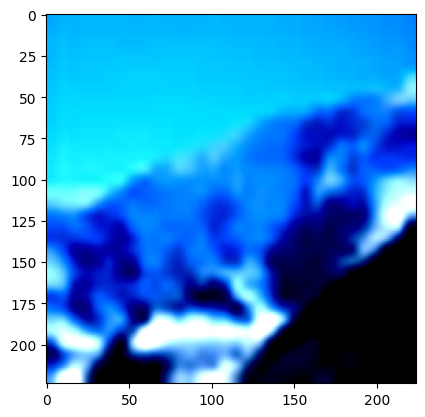

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


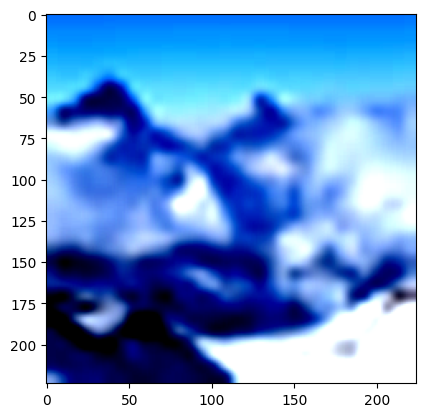

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


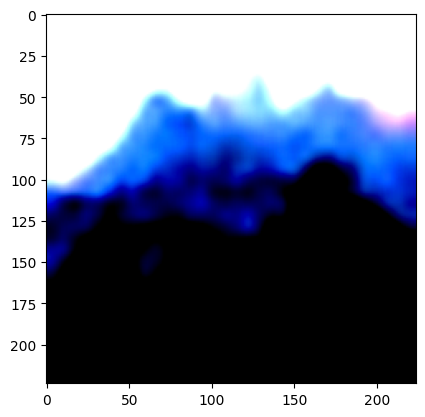

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


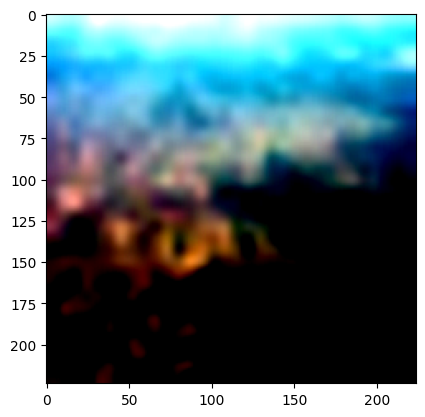

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


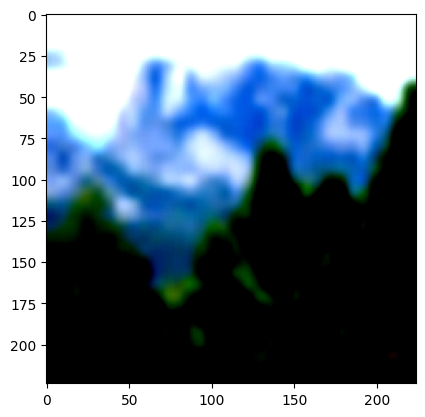

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


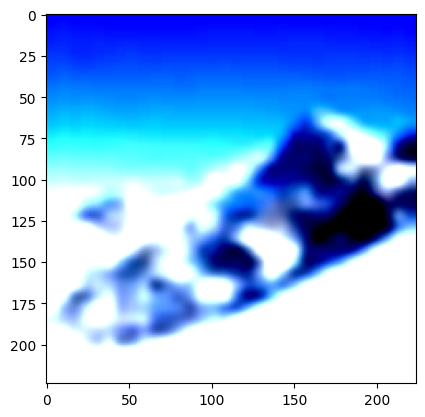

In [8]:
for i, img in enumerate(candidate_images):
    if i > 5:
        break
        
    imshow(img)

## Filter Images

Note: this is the result of the two-pass filter to tackle the second question of the interview.

In [9]:
# Remove images from candidates that are too similar to the exclude images
similarity_threshold = 0.83
filtered_candidates = []
for i, candidate in enumerate(candidate_images):
    #print(similarity[i, :])
    if not any(similarity[i, :] > similarity_threshold):
        filtered_candidates.append(candidate)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


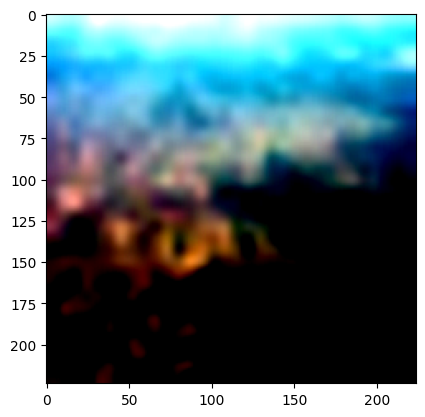

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


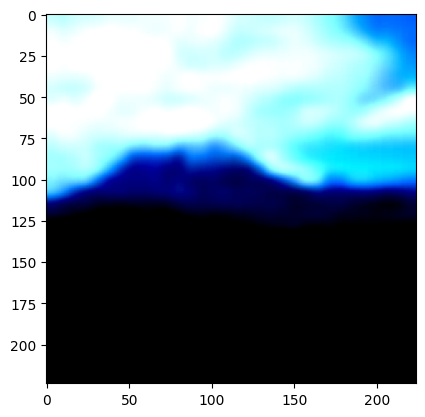

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


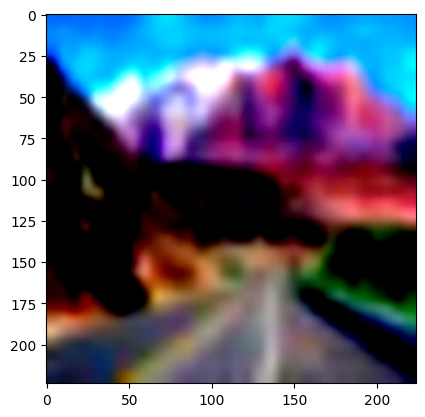

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


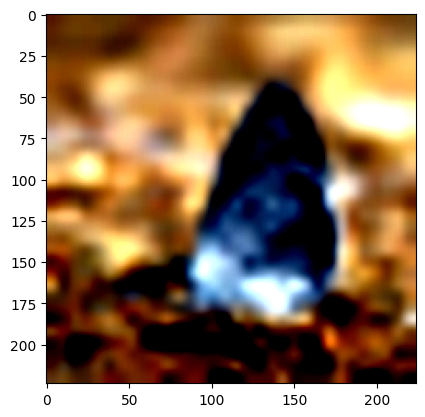

In [10]:
for img in filtered_candidates:
    imshow(img)